In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense
from tensorflow.keras import Model, callbacks, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import datetime

In [2]:
print(tf.config.list_physical_devices('GPU'))
print("GPU:", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow Version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU: 1
Tensorflow Version 2.6.0


In [3]:
batch_size = 64
img_height = 224
img_width = 224
epochs = int(input("Enter epochs number: "))
image_size = 224
input_shape = (image_size, image_size, 3)

Enter epochs number:  10


In [4]:
data_dir = r"D:\Project\4_class_mush\dataset\train"

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16206 files belonging to 4 classes.
Using 12965 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16206 files belonging to 4 classes.
Using 3241 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['amanita', 'boletus', 'cantharellus', 'morchella']


In [8]:
print("Training class names:", train_ds.class_names)
print("Validation class names:", val_ds.class_names)

Training class names: ['amanita', 'boletus', 'cantharellus', 'morchella']
Validation class names: ['amanita', 'boletus', 'cantharellus', 'morchella']


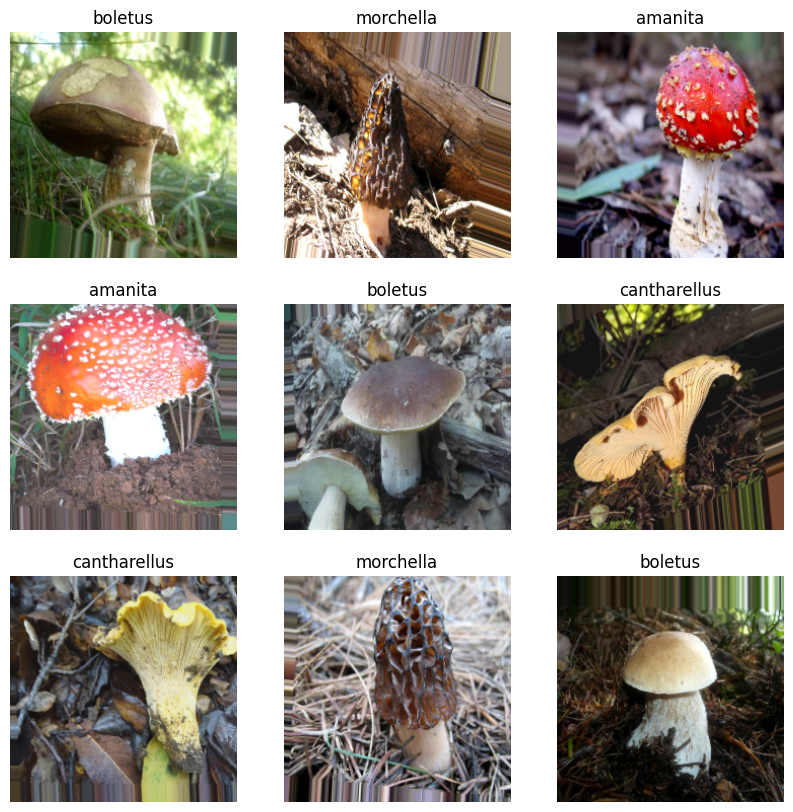

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
densenet = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Allow the base model layers to be trainable
densenet.trainable = True

# Fine-tuning - freeze the first few layers
for layer in densenet.layers[:-10]:
    layer.trainable = False

model = Sequential()
model.add(densenet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(4, activation="softmax"))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 172,228
Non-trainable params: 6,869,376
_________________________________________________________________


In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/10
203/203 [==============================] - 123s 444ms/step - loss: 0.8631 - accuracy: 0.7087 - val_loss: 0.5183 - val_accuracy: 0.9003
Epoch 2/10
203/203 [==============================] - 79s 386ms/step - loss: 0.3232 - accuracy: 0.9591 - val_loss: 0.2297 - val_accuracy: 0.9830
Epoch 3/10
203/203 [==============================] - 73s 356ms/step - loss: 0.1652 - accuracy: 0.9924 - val_loss: 0.1207 - val_accuracy: 0.9975
Epoch 4/10
203/203 [==============================] - 76s 370ms/step - loss: 0.0948 - accuracy: 0.9976 - val_loss: 0.0698 - val_accuracy: 0.9997
Epoch 5/10
203/203 [==============================] - 73s 358ms/step - loss: 0.0604 - accuracy: 0.9996 - val_loss: 0.0461 - val_accuracy: 1.0000
Epoch 6/10
203/203 [==============================] - 74s 359ms/step - loss: 0.0414 - accuracy: 0.9999 - val_loss: 0.0320 - val_accuracy: 1.0000
Epoch 7/10
203/203 [==============================] - 76s 370ms/step - loss: 0.0312 - accuracy: 0.9999 - val_loss: 0.0232 - val_a

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)

In [ ]:
print(test_acc)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def get_true_labels(dataset):
    '''Extracts true labels from a TensorFlow dataset'''
    true_labels = []
    for _, labels in dataset: 
        true_labels.extend(labels.numpy()) 
    return np.array(true_labels)

def conf_matrix(model, dataset, class_types):
    '''Plots confusion matrix and classification report'''
    
    true_labels = get_true_labels(dataset)

    predictions = model.predict(dataset)
    predicted_classes = np.argmax(predictions, axis=1)  # Convert softmax to class indices

    cm = confusion_matrix(true_labels, predicted_classes)

    print("Classification Report:\n")
    print(classification_report(true_labels, predicted_classes, target_names=class_types))

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_types, yticklabels=class_types)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
conf_matrix(model, val_ds, class_names)

In [ ]:
model_version = epochs
next_version = str(int(model_version) + 10) 
#model_filename = f"DenseNet121_{model_version}_ADAM_model.h5"
#model.save(model_filename)
#print(f"Model saved as {model_filename}")

In [ ]:
import shutil

notebook_filename = f"DenseNet121_{model_version}_ADAM.ipynb"
new_notebook_filename = f"DenseNet121_{next_version}_ADAM.ipynb"

shutil.copy(notebook_filename, new_notebook_filename)
print(f"Notebook copied as {new_notebook_filename}")

In [ ]:
os._exit(00)